# Get GPU ready for Machine Learning

In [1]:
# Speed up Machine Learning
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable GPU Memory Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("tf.config.experimental.set_memory_growth = True")

    except RuntimeError as e:
        print(e)
    
# Enable mixed precision training
#mixed_precision.set_global_policy('mixed_float16')

tf.config.experimental.set_memory_growth = True


# Importing Libraries

In [2]:
# Standard libraries
import os
import itertools
import io
import requests
import math
from io import BytesIO

# Data manipulation
import pandas as pd
import numpy as np
import geopandas as gpd
import scipy.io as scio

# Geospatial processing
import rasterio
from rasterio.plot import show, plotting_extent
from rasterio.windows import Window
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.features import rasterize
from shapely.geometry import mapping

# Image processing
import cv2
from PIL import Image
from skimage import exposure
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tifffile as tifff

# Machine learning
import torch
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D, Concatenate
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# SentinelHub
from sentinelhub import SHConfig, MimeType, CRS, BBox, SentinelHubRequest, DataCollection

# Visualization
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

# Custom libraries
from empatches import EMPatches

# Geospatial calculations
from math import radians, cos, sin, degrees, atan2, sqrt


In [86]:
def get_access_token(client_id, client_secret):
    """
    This function sends a POST request to the Sentinel Hub API to obtain an
    access token using the provided client ID and secret.

    Args:
        client_id (str): Sentinel Hub client ID.
        client_secret (str): Sentinel Hub client secret.

    Returns:
        str: The access token.

    Raises:
        Exception: If the request fails.
    """
    url = "https://services.sentinel-hub.com/oauth/token"
    payload = {
        "client_id": client_id,
        "client_secret": client_secret,
        "grant_type": "client_credentials",
    }
    response = requests.post(url, data=payload)
    response.raise_for_status()
    return response.json()["access_token"]

client_id = "<...>"
client_secret = "<...>"
access_token = get_access_token(client_id, client_secret)

HTTPError: 400 Client Error: Bad Request for url: https://services.sentinel-hub.com/oauth/token

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth's surface,
    using the Haversine formula.

    Args:
        lat1, lon1 (float): Latitude and longitude of the first point.
        lat2, lon2 (float): Latitude and longitude of the second point.

    Returns:
        float: The great-circle distance in meters.
    """
    R = 6371000  # Earth radius in meters
    dLat = math.radians(lat2 - lat1)
    dLon = math.radians(lon2 - lon1)
    a = (
        math.sin(dLat / 2) ** 2 +
        math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
        math.sin(dLon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def calculate_bounding_box_and_output_sizes(shapefile_path):
    """
    Calculate the bounding box and output sizes for a given shapefile.

    Args:
        shapefile_path (str): Path to the shapefile.

    Returns:
        tuple: Bounding box, output size X, and output size Y.
    """
    gdf = gpd.read_file(shapefile_path)
    minx, miny, maxx, maxy = gdf["geometry"].total_bounds
    BBOX = [minx, miny, maxx, maxy]

    x_distance = haversine(miny, minx, miny, maxx)
    y_distance = haversine(miny, minx, maxy, minx)

    resolution = 10  # 10 meters per pixel

    OUTPUT_SIZE_X = int(x_distance / resolution)
    OUTPUT_SIZE_Y = int(y_distance / resolution)

    return BBOX, OUTPUT_SIZE_X, OUTPUT_SIZE_Y

shapefile_path = "Fields/Combined/Giedraiciai_fields.shp" # Giedraiciai_fields / Sakiai_fields
BBOX, OUTPUT_SIZE_X, OUTPUT_SIZE_Y = calculate_bounding_box_and_output_sizes(shapefile_path)

print(f"BBOX: {BBOX}")
print(f"Output_X size: {OUTPUT_SIZE_X}")
print(f"Output_Y size: {OUTPUT_SIZE_Y}")

BBOX: [23.44416770119479, 55.521826184636815, 23.63390168519915, 55.625901188779835]
Output_X size: 1194
Output_Y size: 1157


In [5]:
def filter_geometries_within_bounds(gdf, rgb_image_extent):
    """
    This function takes a GeoDataFrame and the extent of an RGB image as input
    and returns a GeoDataFrame containing only the geometries within the bounds
    of the RGB image.

    :param gdf: GeoDataFrame containing the geometries
    :param rgb_image_extent: tuple containing the extent of the RGB image (minx, maxx, miny, maxy)
    :return: GeoDataFrame with geometries within the bounds of the RGB image
    """
    # Check if each geometry's bounding box is within the extent of the RGB image
    within_bounds = gdf.geometry.bounds.apply(
        lambda row: (
            row['minx'] >= rgb_image_extent[0] and
            row['miny'] >= rgb_image_extent[2] and
            row['maxx'] <= rgb_image_extent[1] and
            row['maxy'] <= rgb_image_extent[3]
        ), axis=1
    )

    # Keep only the fields within the bounds of the RGB image
    gdf_within_bounds = gdf[within_bounds]

    return gdf_within_bounds

In [7]:
url = "https://services.sentinel-hub.com/api/v1/process"
headers = {
  "Content-Type": "application/json",
  "Authorization": "Bearer " + access_token
}
data = {
  "input": {
    "bounds": {
      "bbox": BBOX, 
      "properties": {
        "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
      }
    },
    "data": [
      {
        "dataFilter": {
            "timeRange": {
                "from": "2017-05-01T00:00:00Z",
                "to": "2017-10-01T23:59:59Z"
          },
            "mosaickingOrder": "leastCC"
        },
        "type": "sentinel-2-l2a"
      }
    ]
  },
  "output": {
    "width": OUTPUT_SIZE_X,
    "height": OUTPUT_SIZE_Y,
    "crs": "http://www.opengis.net/def/crs/EPSG/0/4326",
    "responses": [
        {
            "identifier": "Response",
                "format": {
                    "type": "image/tiff"
                },
            "properties": {
                "crs": "http://www.opengis.net/def/crs/EPSG/0/4326"
            }
        }
    ]
  },
  "evalscript": """
  //VERSION=3
  function setup() {
    return {
        input: ["B02", "B03", "B04", "sunZenithAngles", "B08"],
        output: [
                {id: "Response", bands: 5, sampleType: SampleType.FLOAT32}
            ]
    };
    }

    function evaluatePixel(sample) {
        var response = [sample.B04, sample.B03, sample.B02, sample.B04, sample.B08];
        var sza = [sample.sunZenithAngles];
        
        if (sza > 80) {
            return {
                Response: response
            };
        } else {
            return {
                Response: response
            };
        }
    }
    """
}
response = requests.post(url, headers=headers, json=data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


CRS: EPSG:4326
Bounds: BoundingBox(left=23.44416770119479, bottom=55.521826184636815, right=23.63390168519915, top=55.625901188779835)


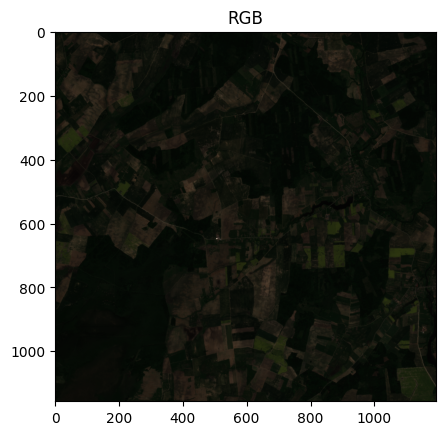

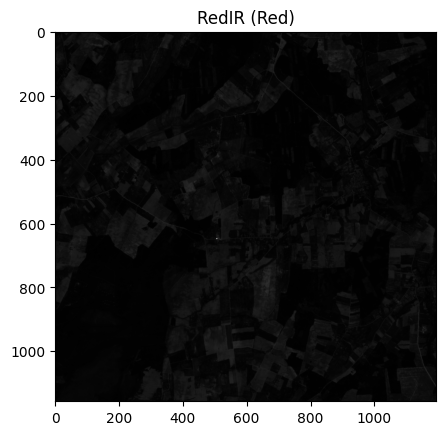

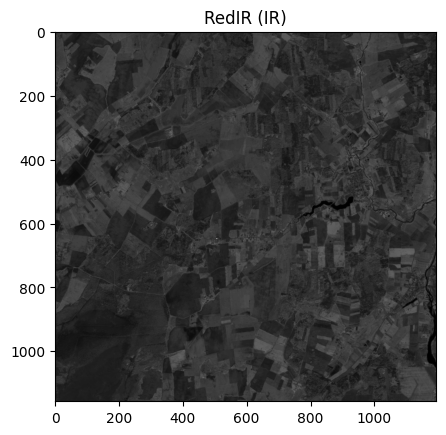

In [8]:
image_content = response.content

# Retrieve CRS and bounds from the image content
with MemoryFile(image_content) as memfile:
    with memfile.open() as src:
        default_crs = src.crs
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        profile = src.profile

# Read image data using tifffile
with tifff.TiffFile(BytesIO(image_content)) as tif:
    response_image_data = tif.pages[0].asarray()

# Extract RGB and RedIR data from the image
rgb_image = response_image_data[:, :, 0:3]
redir_image = response_image_data[:, :, [0, 4]]

# Display RGB image
plt.imshow(rgb_image)
plt.title("RGB")
plt.show()

# Display RedIR image (Red channel)
plt.imshow(redir_image[:, :, 0], cmap='gray')
plt.title("RedIR (Red)")
plt.show()

# Display RedIR image (IR channel)
plt.imshow(redir_image[:, :, 1], cmap='gray')
plt.title("RedIR (IR)")
plt.show()

In [9]:
def load_shapefile(shapefile_path):
    """
    Loads a shapefile using GeoPandas and adds a 'field_id' column.
    
    Parameters:
    shapefile_path (str): Path to the input shapefile.
    
    Returns:
    GeoDataFrame: A GeoDataFrame containing the geometries and field_id.
    """
    gdf = gpd.read_file(shapefile_path)
    gdf = gdf.loc[:, ["geometry"]]
    gdf['field_id'] = range(1, len(gdf) + 1)
    return gdf

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


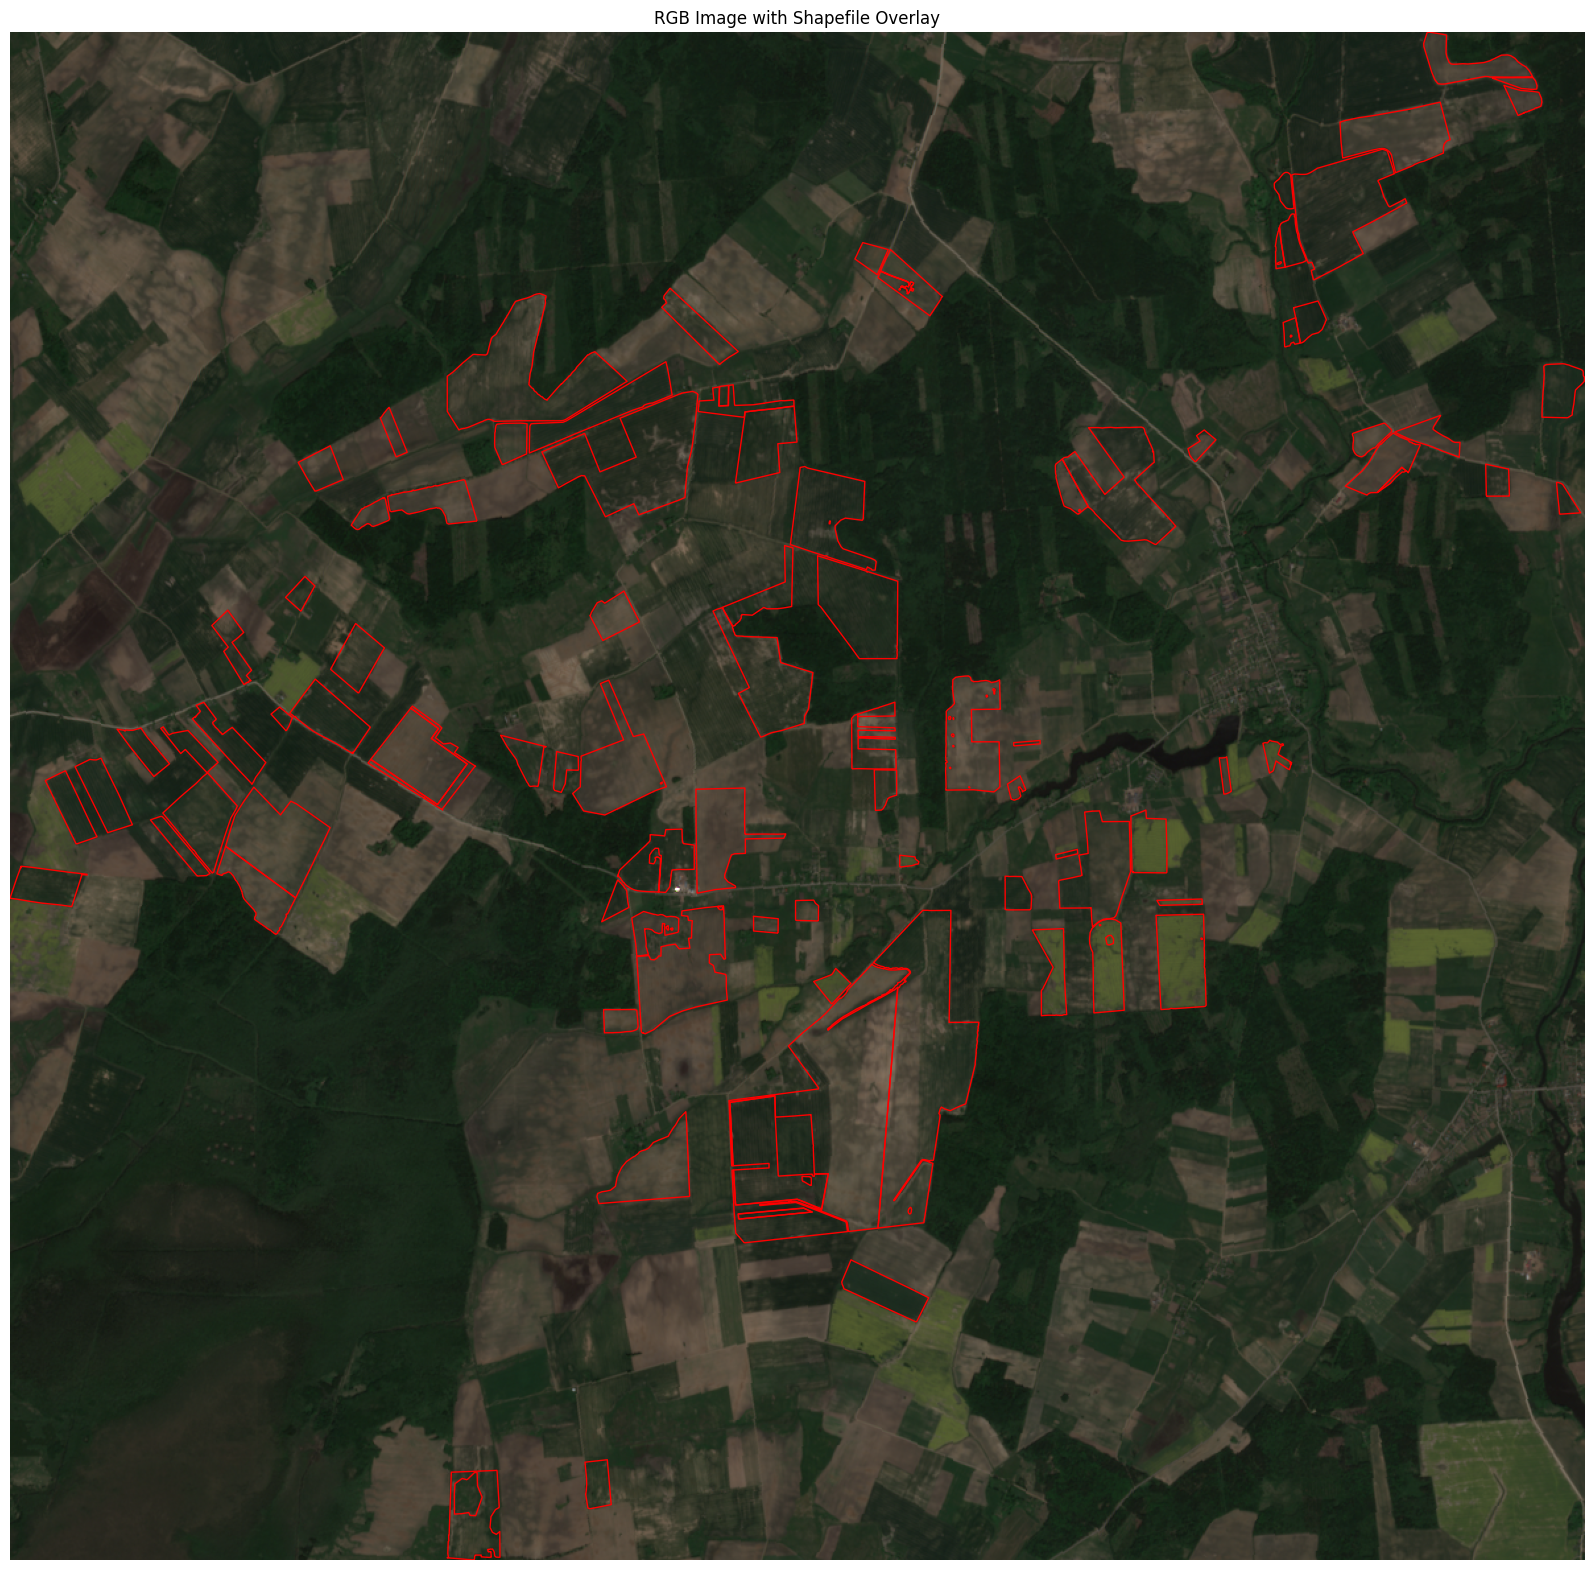

In [10]:
# Save Red + IR image
profile.update(count=2)
with rasterio.open("RedIR_IMAGE.tif", "w", **profile) as dst:
    dst.write(redir_image.transpose(2, 0, 1))

# Save RGB image
profile.update(count=3)
with rasterio.open("RGB_IMAGE.tif", "w", **profile) as dst:
    dst.write(rgb_image.transpose(2, 0, 1))

# Read combined shapefile
gdf = load_shapefile('Fields/Combined/Combined_fields.shp')

# Display RGB image with shapefile overlay
with rasterio.open('RGB_IMAGE.tif') as src:
    rgb_image_extent = plotting_extent(src)
    gdf_within_bounds = filter_geometries_within_bounds(gdf, rgb_image_extent)
    
    bands = src.read()
    height, width = bands.shape[1:]
    aspect_ratio = width / height
    adjusted_image = exposure.adjust_gamma(bands, gamma = 0.6)

    fig_width = 2048
    fig_height = int(fig_width / aspect_ratio)
    fig, ax = plt.subplots(figsize=(fig_width / 100, fig_height / 100))

    ax.imshow(np.transpose(adjusted_image, (1, 2, 0)), extent=rgb_image_extent)
    gdf_within_bounds.boundary.plot(ax=ax, linewidth=1, edgecolor='red')

    ax.set_title("RGB Image with Shapefile Overlay")
    ax.axis('off')

    plt.savefig('image_output/Image_with_Shapefile.png', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()


In [334]:
def calculate_ndvi(nir_band, red_band):
    with np.errstate(divide='ignore', invalid='ignore'):
        ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi

# Read the Red + IR image and calculate the NDVI values
with rasterio.open('RedIR_IMAGE.tif') as src:
    red_band = src.read(1).astype(float)
    nir_band = src.read(2).astype(float)
    ndvi = calculate_ndvi(nir_band, red_band)

# Create a masked NDVI array and set all values to a "no data" value (e.g., -9999)
masked_ndvi = np.full_like(ndvi, -9999, dtype=float)

# Replace masked NDVI array's values with calculated NDVI values for areas specified in the shapefile
for geometry in gdf_within_bounds.geometry:
    with rasterio.open('RedIR_IMAGE.tif') as src:
        out_image, out_transform = mask(src, [geometry], crop=True)
        masked_ndvi_part = out_image[[0, 1]]  # Select Red + IR bands
        masked_ndvi_part = calculate_ndvi(masked_ndvi_part[1].astype(float), masked_ndvi_part[0].astype(float))
        window = rasterio.features.geometry_window(src, [geometry])
        masked_ndvi[window.row_off:window.row_off+window.height, window.col_off:window.col_off+window.width] = masked_ndvi_part

# Display the RGB image and overlay the masked NDVI array using a colormap that highlights NDVI values
width, height = rgb_image.shape[1], rgb_image.shape[0]
aspect_ratio = width / height
fig_width = 2048
fig_height = int(fig_width / aspect_ratio)
fig, ax = plt.subplots(figsize=(fig_width/100, fig_height/100))

ax.imshow(exposure.adjust_gamma(rgb_image, 0.6))
ndvi_masked_overlay = np.ma.masked_where(masked_ndvi == -9999, masked_ndvi)
im = ax.imshow(ndvi_masked_overlay, cmap='RdYlGn', vmin=-1, vmax=1, alpha=0.7)
ax.axis('off')

# Add a colorbar
cax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cax, orientation='vertical')

# Save the image at the highest quality with a resolution of 2048 x 2048
plt.savefig('image_output/Image_with_Shapefile_and_NDVI.png', dpi=100, bbox_inches='tight', pad_inches=0)
plt.show()

TypeError: 'numpy.ndarray' object is not callable

In [426]:
def read_band_image(satellite_path):
    """
    Reads a multi-band image using rasterio and returns the image data,
    coordinate reference system (CRS), and geotransform.
    
    Parameters:
    satellite_path (str): Path to the input image file.
    
    Returns:
    tuple: A tuple containing the image data as a NumPy array,
           CRS, and geotransform.
    """
    with rasterio.open(satellite_path) as img_ds:
        data = np.zeros((img_ds.height, img_ds.width, img_ds.count))

        for b in range(data.shape[2]):
            data[:, :, b] = np.array(img_ds.read(b+1))

        crs = img_ds.crs
        geo_transform = img_ds.transform

    return data, crs, geo_transform

satellite1, crs1, geo_transform1 = read_band_image('RGB_IMAGE_SAKIAI.tif')
satellite2, crs2, geo_transform2 = read_band_image('RGB_IMAGE_GIEDRAICIAI.tif')

print(satellite1.shape, crs1)
print(satellite2.shape, crs2)

(1189, 1959, 3) EPSG:4326
(1157, 1194, 3) EPSG:4326


In [427]:
shapefile_path_sakiai = "Fields/Combined/Sakiai_fields.shp"
gdf_sakiai = load_shapefile(shapefile_path_sakiai)
print("Sakiai: ", gdf_sakiai)

shapefile_path_giedr = "Fields/Combined/Giedraiciai_fields.shp"
gdf_giedr = load_shapefile(shapefile_path_giedr)
print("Giedraiciai: ", gdf_giedr)

Sakiai:                                                geometry  field_id
0    POLYGON ((23.08267 54.94451, 23.08244 54.94454...         1
1    POLYGON ((23.08190 54.94476, 23.08149 54.94504...         2
2    POLYGON ((23.08420 54.94586, 23.08278 54.94598...         3
3    POLYGON ((23.01395 54.95435, 23.01166 54.95459...         4
4    POLYGON ((23.01270 54.95461, 23.01270 54.95461...         5
..                                                 ...       ...
97   POLYGON ((23.11189 54.96937, 23.11176 54.96939...        98
98   POLYGON ((23.09894 54.97271, 23.09862 54.97260...        99
99   POLYGON ((22.98223 54.97745, 22.98150 54.97746...       100
100  POLYGON ((23.06868 55.00552, 23.06836 55.00890...       101
101  POLYGON ((22.92129 55.03840, 22.92167 55.03841...       102

[102 rows x 2 columns]
Giedraiciai:                                                geometry  field_id
0    POLYGON ((23.52152 55.60063, 23.52149 55.60063...         1
1    POLYGON ((23.56658 55.57429, 23.56654 

In [428]:
def calculate_area_km2(gdf):
    """
    Calculate the area in square kilometers for each geometry in the input GeoDataFrame.
    
    Parameters:
    gdf (GeoDataFrame): Input GeoDataFrame with geometries.
    
    Returns:
    GeoDataFrame: A new GeoDataFrame with projected geometries and an 'area_km2' column.
    """
    # Get the UTM zone number based on the centroid of the first geometry
    first_geometry = gdf.geometry.iloc[0]
    centroid = first_geometry.centroid
    utm_zone = int((centroid.x + 186) / 6) + 1

    # Create the UTM CRS string
    utm_crs = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +no_defs"

    # Project the geometries to the UTM coordinate system
    gdf_projected = gdf.to_crs(utm_crs)

    # Calculate the area of the projected geometries in square kilometers
    gdf_projected['area_km2'] = gdf_projected.geometry.area / 1e4

    return gdf_projected

# Calculate the area of the polygons in both shapefiles
sakiai_gdf = calculate_area_km2(gdf_sakiai)
giedraiciai_gdf = calculate_area_km2(gdf_giedr)

# Print the sum of the area_km2 column for both DataFrames
print("Total area for Sakiai (km2):", sakiai_gdf['area_km2'].sum())
print("Total area for Giedraiciai (km2):", giedraiciai_gdf['area_km2'].sum())


Total area for Sakiai (km2): 744.0831028291858
Total area for Giedraiciai (km2): 1366.2339953751718


In [429]:
def rasterize_shapefile_from_image(gdf, satellite_image_path):
    """
    Rasterize a shapefile based on an input satellite image.
    
    Parameters:
    gdf (GeoDataFrame): Input GeoDataFrame with geometries.
    satellite_image_path (str): Path to the satellite image file.
    
    Returns:
    numpy.ndarray: Rasterized shapefile as a NumPy array.
    """
    with rasterio.open(satellite_image_path) as src:
        transform = src.transform
        crs = src.crs
        width = src.width
        height = src.height

        # Rasterize the shapefile using the satellite image's transform, width, and height
        shapes = ((geom, 1) for geom, value in zip(gdf.geometry, gdf['field_id']))
        cls = rasterize(shapes, out_shape=(height, width), fill=0, transform=transform, dtype=rasterio.int16)
        
        # Add a new axis to the NumPy array
        cls = np.expand_dims(cls, axis=-1)

    return cls

satellite_image_path_sakiai = "RGB_IMAGE_SAKIAI.tif"
cls1 = rasterize_shapefile_from_image(gdf_sakiai, satellite_image_path_sakiai)
print(cls1.shape)

satellite_image_path_giedr = "RGB_IMAGE_GIEDRAICIAI.tif"
cls2 = rasterize_shapefile_from_image(gdf_giedr, satellite_image_path_giedr)
print(cls2.shape)

(1189, 1959, 1)
(1157, 1194, 1)


In [430]:
def filter_patches(X, y, threshold=0.5):
    """
    Filter patches based on a threshold percentage of non-zero pixels in the y array.
    
    Parameters:
    X (numpy.ndarray): Input array X.
    y (numpy.ndarray): Input array y.
    threshold (float): Threshold percentage of non-zero pixels to consider for filtering.
    
    Returns:
    tuple: Filtered X and y arrays.
    """
    min_required_pixels = int(y.shape[1] * y.shape[2] * threshold)

    # Create a list of indices for patches that meet the threshold condition
    filtered_indices = [
        i for i in range(y.shape[0])
        if np.sum(y[i] > 0) >= min_required_pixels
    ]

    # Filter the X and y arrays using the filtered_indices
    X_filtered = X[filtered_indices]
    y_filtered = y[filtered_indices]
    
    return X_filtered, y_filtered


In [431]:
sample_stride = 8
sample_size = 64
sample_overlap = 0.1

# load module
emp = EMPatches()

X1, indices1 = emp.extract_patches(satellite1, patchsize=sample_size, overlap=sample_overlap, stride=sample_stride)
y1, indices1 = emp.extract_patches(cls1, patchsize=sample_size, overlap=sample_overlap, stride=sample_stride)

X2, indices2 = emp.extract_patches(satellite2, patchsize=sample_size, overlap=sample_overlap, stride=sample_stride)
y2, indices2 = emp.extract_patches(cls2, patchsize=sample_size, overlap=sample_overlap, stride=sample_stride)

X1 = np.array(X1)
y1 = np.array(y1)
X2 = np.array(X2)
y2 = np.array(y2)

X = np.concatenate((X1, X2), axis=0)
y = np.concatenate((y1, y2), axis=0)

print("Before filter", X.shape, y.shape)

# Apply the filter with threshold of non-zero pixels
X, y = filter_patches(X, y, threshold=0.75)

print("After filter", X.shape, y.shape)

Before filter (53530, 64, 64, 3) (53530, 64, 64, 1)
After filter (603, 64, 64, 3) (603, 64, 64, 1)


In [432]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(542, 64, 64, 3) (542, 64, 64, 1) (61, 64, 64, 3) (61, 64, 64, 1)


# Model training

In [433]:
def conv_block(inputs, filters):
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Contracting path (Encoder)
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)

    # Expanding path (Decoder)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])

    return model


# Example usage:
input_shape = (64, 64, 3)  # Adjust according to the desired input shape
num_classes = 1  # Adjust according to the number of classes in the segmentation task
model = unet(input_shape, num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_266 (Conv2D)            (None, 64, 64, 64)   1792        ['input_15[0][0]']               
                                                                                                  
 conv2d_267 (Conv2D)            (None, 64, 64, 64)   36928       ['conv2d_266[0][0]']             
                                                                                                  
 max_pooling2d_56 (MaxPooling2D  (None, 32, 32, 64)  0           ['conv2d_267[0][0]']             
 )                                                                                         

In [434]:
def data_generator(X, y, batch_size=32, seed=42):
    data_gen_args = dict(
        rotation_range=360,
        horizontal_flip=True,
        vertical_flip=True,
    )

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_datagen.fit(X, augment=True, seed=seed)
    mask_datagen.fit(y, augment=True, seed=seed)

    image_generator = image_datagen.flow(X, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(y, batch_size=batch_size, seed=seed)

    train_generator = zip(image_generator, mask_generator)
    return train_generator

In [435]:
# Train the model
batch_size = 16
num_epochs = 50
steps_per_epoch = int(np.ceil(X_train.shape[0] / batch_size))

X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

train_generator = data_generator(X_train, y_train, batch_size=batch_size)

# Calculate the number of generated samples after applying augmentations
num_generated_samples = steps_per_epoch * batch_size * num_epochs
print(f"Total number of generated samples after data augmentation: {num_generated_samples}")

early_stopping = EarlyStopping(patience=5, verbose=1)
model_checkpoint = ModelCheckpoint('Models/Model_Checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Total number of generated samples after data augmentation: 27200
Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.8281
Epoch 1: val_loss improved from inf to 0.39474, saving model to Models\Model_Checkpoint.h5
34/34 [==============================] - 4s 79ms/step - loss: 0.4098 - accuracy: 0.8281 - val_loss: 0.3947 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8450
Epoch 2: val_loss improved from 0.39474 to 0.38417, saving model to Models\Model_Checkpoint.h5
34/34 [==============================] - 2s 69ms/step - loss: 0.3372 - accuracy: 0.8450 - val_loss: 0.3842 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8485
Epoch 3: val_loss did not improve from 0.38417
34/34 [==============================] - 2s 65ms/step - loss: 0.3519 - accuracy: 0.8485 - val_loss: 0.3983 - val_accuracy: 0.8471 - lr

In [436]:
model.save('Models/My_Model.h5')

1/1 [==============================] - 0s 18ms/step
(61, 64, 64, 3)


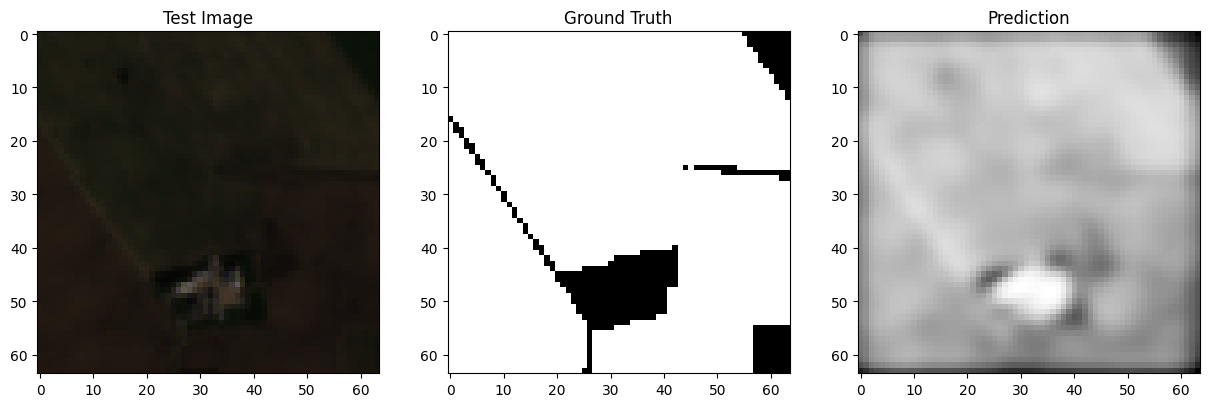

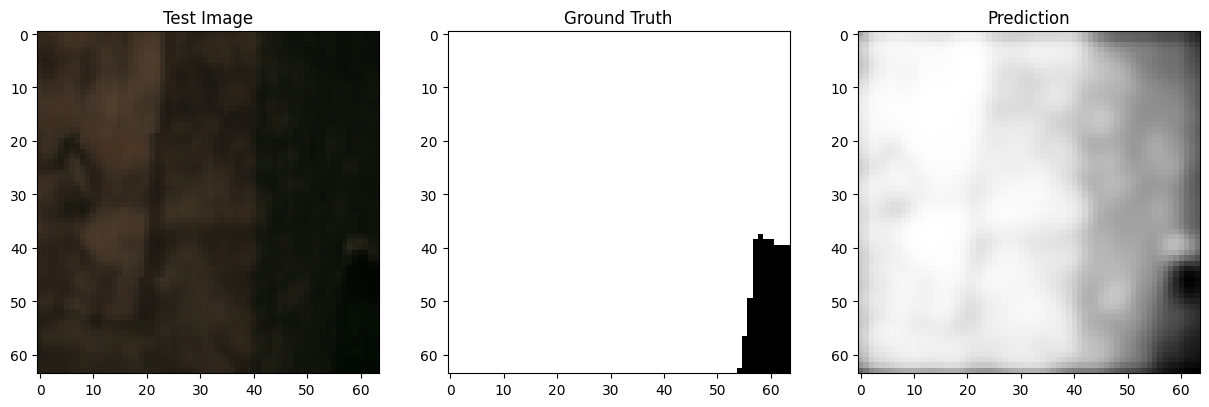

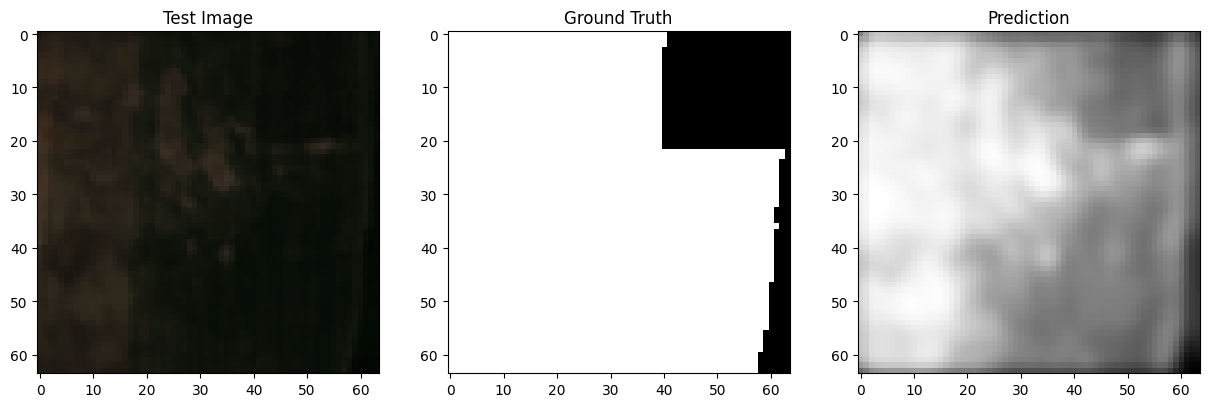

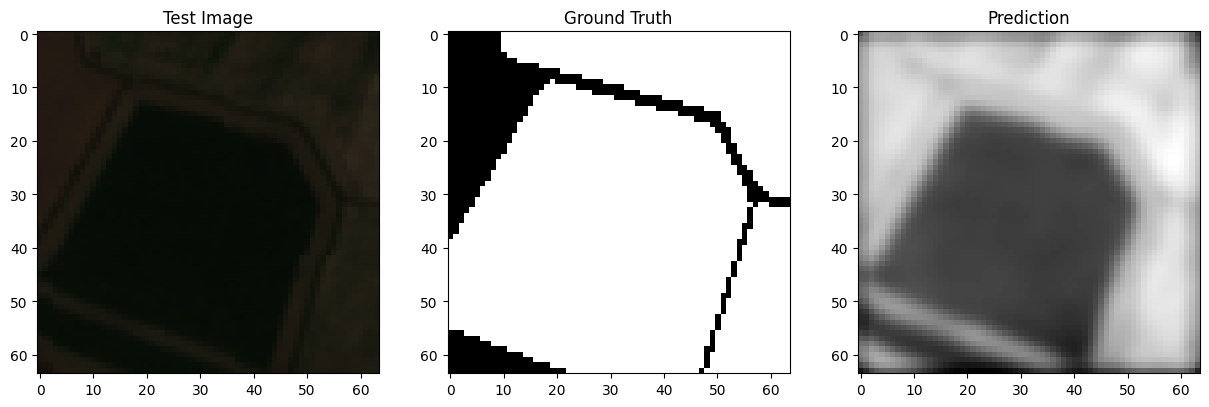

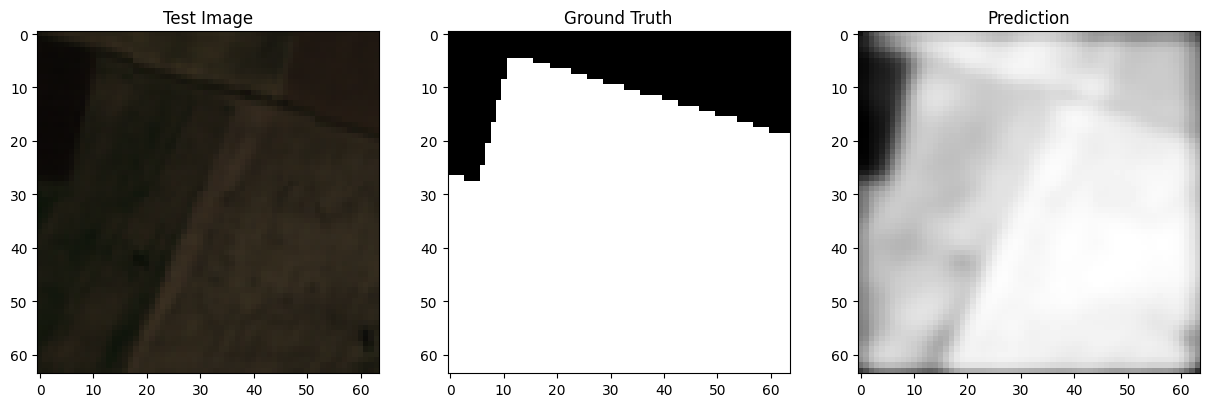

In [454]:
from keras.models import load_model

# model = load_model('Models/Model_Checkpoint.h5')

# Generate predictions for a few test images
num_test_images_to_display = 5
predictions = model.predict(X_test[:num_test_images_to_display])

print(X_test.shape)

# Plot the test images, ground truth, and predictions
for i in range(num_test_images_to_display):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(X_test[i])
    ax1.set_title("Test Image")

    ax2.imshow(y_test[i].squeeze(), cmap="gray")
    ax2.set_title("Ground Truth")

    ax3.imshow(predictions[i].squeeze(), cmap="gray")
    ax3.set_title("Prediction")

    plt.show()


In [455]:
df_result = pd.DataFrame(history.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

loss  accuracy  val_loss  val_accuracy     lr
5   0.332588  0.844314  0.378148      0.847760  0.001
6   0.332755  0.846751  0.378208      0.851494  0.001
4   0.340060  0.844291  0.382766      0.847120  0.001
1   0.337209  0.844987  0.384171      0.849341  0.001
10  0.342854  0.843997  0.387779      0.848056  0.001
8   0.338622  0.849735  0.389768      0.856341  0.001
9   0.340272  0.848525  0.393025      0.847180  0.001
7   0.329759  0.851393  0.393464      0.850926  0.001
0   0.409762  0.828115  0.394745      0.847076  0.001
2   0.351904  0.848458  0.398300      0.847076  0.001
3   0.345152  0.844826  0.398698      0.847076  0.001

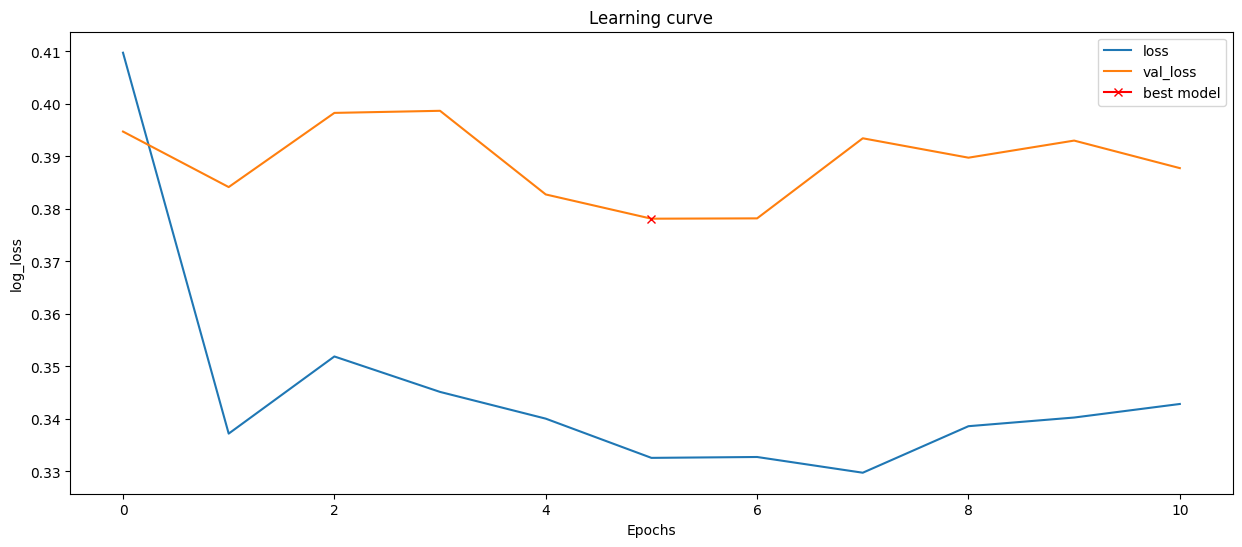

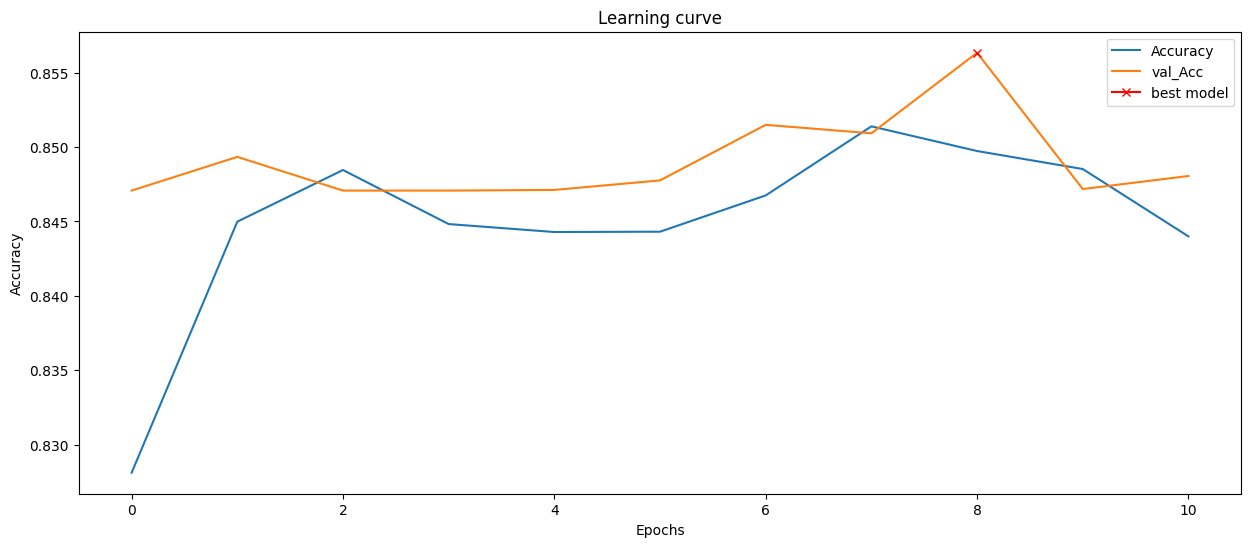

In [456]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="val_Acc")
plt.plot(np.argmax(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [457]:
(satellite3, crs3, geoTransform3) = read_band_image('RGB_IMAGE_TESTING.tif')
print(satellite1.shape, crs1)

(1189, 1959, 3) EPSG:4326


In [458]:
sample_stride = 64
sample_size = 64
sample_overlap = 0
# load module
emp = EMPatches()

X3, indices3 = emp.extract_patches(satellite3, patchsize=sample_size, overlap=sample_overlap, stride=sample_stride)

print(X3[0].shape)

(64, 64, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


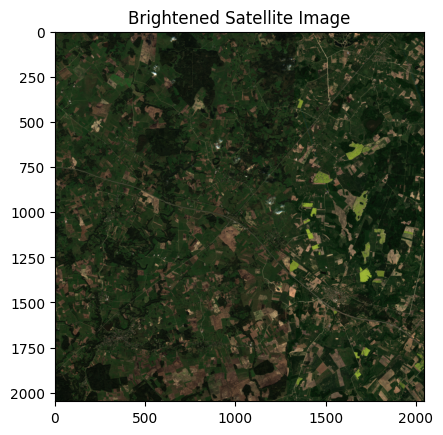

In [459]:
# Increase the brightness by a scale factor
scale_factor = 3
brightened_image = np.clip(satellite3 * scale_factor, 0, 255)

plt.imshow(brightened_image)
plt.title("Brightened Satellite Image")
plt.show()

1/1 [==============================] - 0s 19ms/step


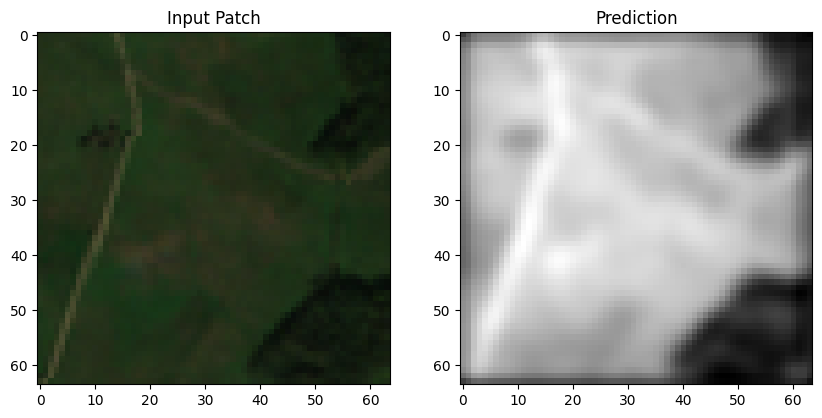

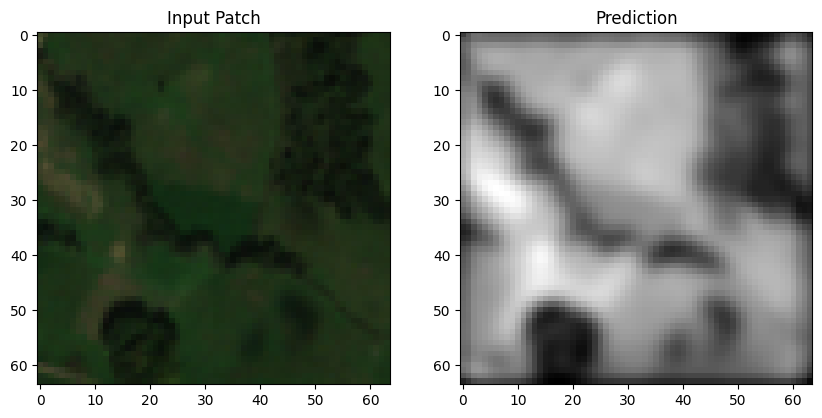

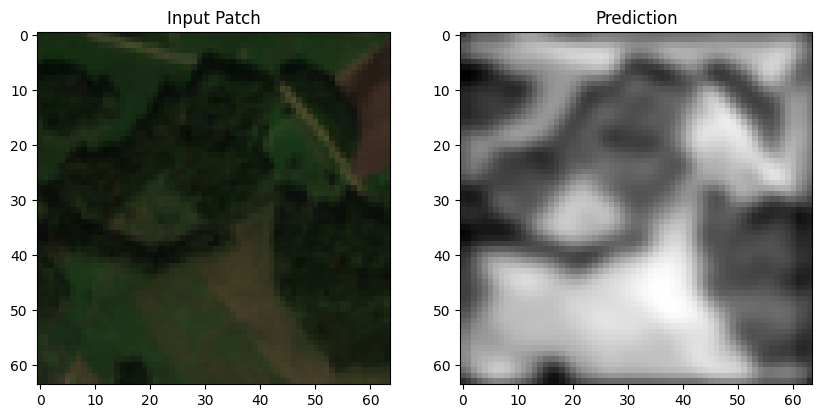

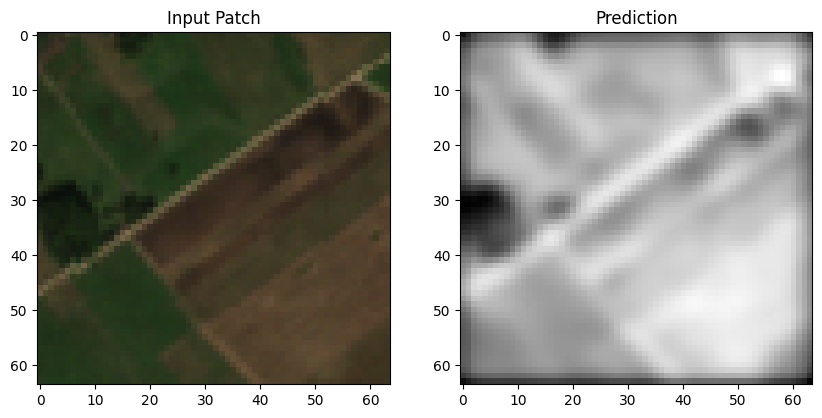

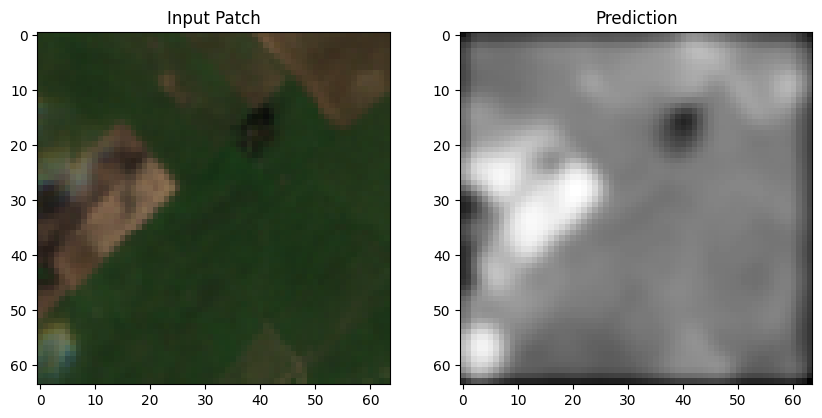

In [460]:
# Generate predictions for a few patches in X3
num_patches_to_display = 5
predictions = model.predict(np.array(X3[:num_patches_to_display]))

# Increase the brightness by a scale factor
scale_factor = 3

# Plot the input patches and predictions
for i in range(num_patches_to_display):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Increase the brightness of the input patch
    brightened_patch = np.clip(X3[i] * scale_factor, 0, 255)

    ax1.imshow(brightened_patch)
    ax1.set_title("Input Patch")

    ax2.imshow(predictions[i].squeeze(), cmap="gray")
    ax2.set_title("Prediction")

    plt.show()


32/32 [==============================] - 1s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


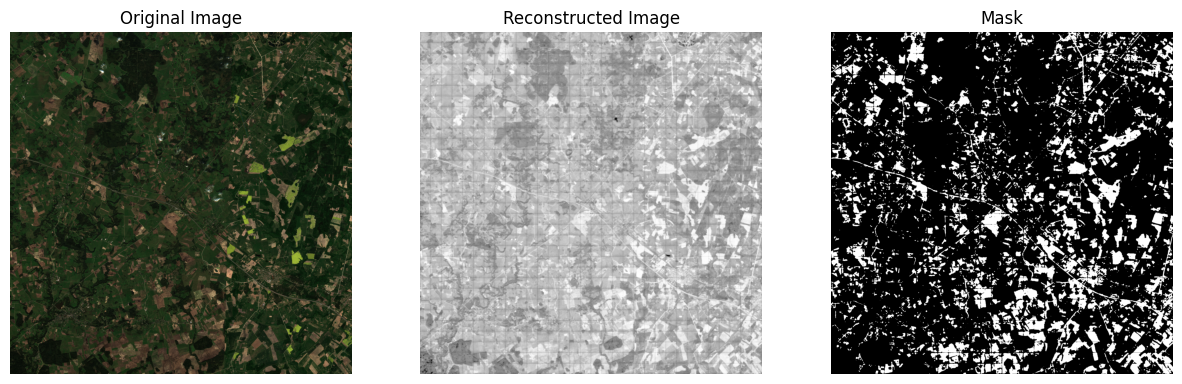

In [470]:
# Predict on all patches in X3
all_predictions = model.predict(np.array(X3))

# Reconstruct the predicted image
reconstructed_image = emp.merge_patches(all_predictions, indices3, mode='max')

# Threshold the predictions to create a binary mask
threshold = 0.8
mask = np.where(reconstructed_image > threshold, 1, 0)

# Display the original image, reconstructed image, and mask
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(brightened_image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(reconstructed_image.squeeze(), cmap="gray")
ax2.set_title("Reconstructed Image")
ax2.axis("off")

ax3.imshow(mask.squeeze(), cmap="gray")
ax3.set_title("Mask")
ax3.axis("off")

# Save the figure with the highest quality
plt.savefig('image_output/mask_image.png', dpi=300, bbox_inches='tight', pad_inches=0)

plt.show()

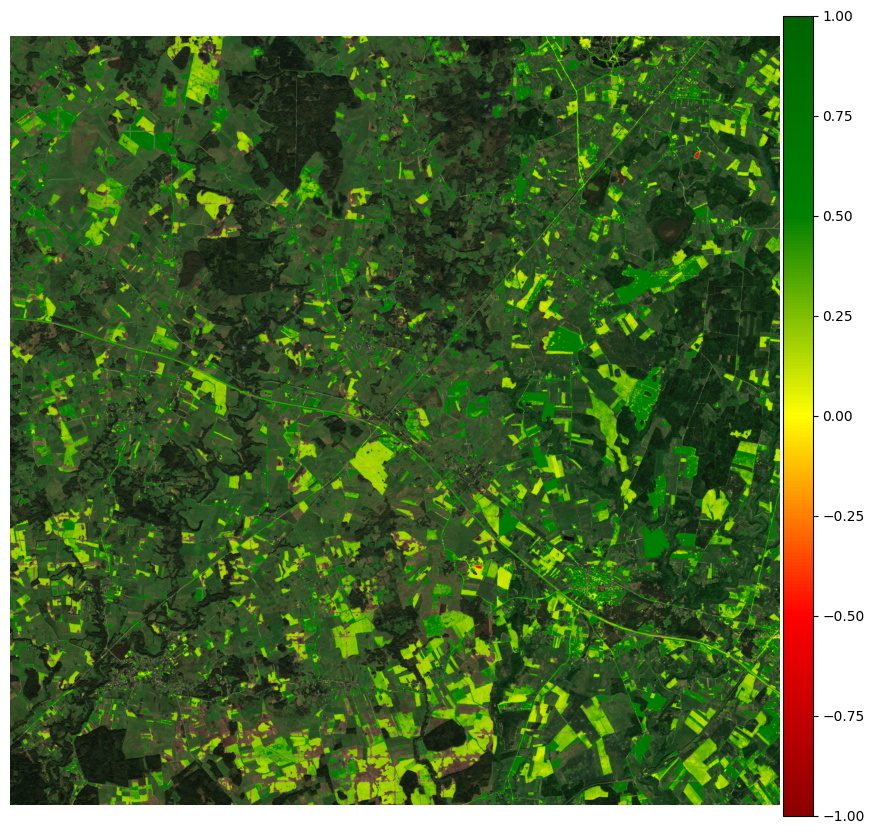

In [471]:
import numpy as np
import rasterio
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def calculate_ndvi(nir_band, red_band):
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return ndvi

# Read the RGB image
with rasterio.open('RGB_IMAGE_TESTING.tif') as src:
    rgb_image = np.transpose(src.read(), (1, 2, 0)).astype(np.float32)

# Read the Red and NIR images
with rasterio.open('RedIR_IMAGE_TESTING.tif') as src:
    red_band = src.read(1).astype(float)
    nir_band = src.read(2).astype(float)

# Calculate NDVI
ndvi = calculate_ndvi(nir_band, red_band)

# Normalize the NDVI values to the range [0, 1]
ndvi_normalized = (ndvi + 1) / 2

# Define custom colormap
colors = ["darkred", "red", "yellow", "green", "darkgreen"]
cmap = LinearSegmentedColormap.from_list("ndvi", colors)

# Convert the normalized NDVI values to RGB colors using the custom colormap
ndvi_rgb = cmap(ndvi_normalized)

# Take only the first 3 channels
ndvi_rgb = ndvi_rgb[:,:,:3]

# Increase RGB image brightness
brightness_factor = 5
rgb_image = np.clip(rgb_image * brightness_factor, 0, 1)

mask = mask.astype(bool)

# Apply the mask
output_image = np.where(mask, ndvi_rgb, rgb_image)

# Plot the output image and colorbar
fig, ax = plt.subplots(figsize=(10, 10))

cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
ndvi_colorbar = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
fig.colorbar(ndvi_colorbar, cax=cax, orientation='vertical')

ax.imshow(output_image)
ax.axis('off')

plt.savefig('image_output/final_ndvi_output.png', dpi=300, bbox_inches='tight', pad_inches=0, format='png')
plt.show()


In [472]:
print(f"Mask shape: {mask.shape}, type: {mask.dtype}")
print(f"NDVI RGB shape: {ndvi_rgb.shape}, type: {ndvi_rgb.dtype}")
print(f"RGB image shape: {rgb_image.shape}, type: {rgb_image.dtype}")
print(f"Output image shape: {output_image.shape}, type: {output_image.dtype}")
print(np.unique(mask))


Mask shape: (2048, 2048, 1), type: bool
NDVI RGB shape: (2048, 2048, 3), type: float64
RGB image shape: (2048, 2048, 3), type: float32
Output image shape: (2048, 2048, 3), type: float64
[False  True]
